In [1]:
# 1. Setup
import sys
sys.path.append(r'E:\bs_project/src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.optimize import brentq
import yfinance as yf

from bs_model import black_scholes, bs_greeks

In [3]:
# 2. Settings
ticker_symbol = 'AAPL'
expiry = '2025-06-20'
risk_free_rate = 0.042

In [5]:
# 3. Estimate Dividend Yield
ticker = yf.Ticker(ticker_symbol)
spot_price = ticker.history(period='1d')['Close'].iloc[-1]
dividends = ticker.dividends

dividends.index = dividends.index.tz_localize(None)
current_time = pd.Timestamp.today().tz_localize(None)
recent_divs = dividends[dividends.index > (pd.Timestamp.today() - pd.DateOffset(months=12))]
total_div = recent_divs.sum()
div_yield = total_div / spot_price if total_div > 0 else 0.0

In [7]:
# 4. Time to Expiry
expiry_date = pd.to_datetime(expiry).tz_localize(None)
current_date = pd.Timestamp.today().tz_localize(None)
T_days = (expiry_date - current_date).days
T = T_days / 365

In [9]:
# 5. Historical Volatility
hist_data = ticker.history(period='6mo')
daily_returns = hist_data['Close'].pct_change().dropna()
hist_vol = np.std(daily_returns) * np.sqrt(252)

In [11]:
# 6. Option Chain
opt_chain = ticker.option_chain(expiry)
calls = opt_chain.calls

In [13]:
# Determine market price column
market_price_col = 'lastPrice' if 'lastPrice' in calls.columns else None
if market_price_col is None:
    if 'bid' in calls.columns and 'ask' in calls.columns:
        calls['midPrice'] = (calls['bid'] + calls['ask']) / 2
        market_price_col = 'midPrice'
    else:
        raise ValueError("Cannot determine market price column from options data")

In [15]:
# 7. Price Calculations and Greeks
hist_results = []
iv_results = []

def implied_vol_solver(market_price, S, K, T, r, option_type):
    try:
        objective = lambda sigma: black_scholes(S, K, T, r, sigma, option_type, q=div_yield) - market_price
        return brentq(objective, 1e-6, 5)
    except:
        return np.nan

for idx, row in calls.iterrows():
    strike = row['strike']
    market_price = row[market_price_col]
    if pd.isna(market_price) or market_price < 0.1:
        continue

    # Historical Vol pricing
    model_price_hist = black_scholes(spot_price, strike, T, risk_free_rate, hist_vol, 'call', q=div_yield)
    hist_results.append({
        'Strike': strike,
        'Market Price': market_price,
        'Model Price': model_price_hist,
        'Implied Volatility': hist_vol
    })

    # Implied Vol pricing
    imp_vol = implied_vol_solver(market_price, spot_price, strike, T, risk_free_rate, 'call')
    if np.isnan(imp_vol):
        continue

    model_price_imp = black_scholes(spot_price, strike, T, risk_free_rate, imp_vol, 'call', q=div_yield)
    delta, gamma, vega, theta, rho = bs_greeks(spot_price, strike, T, risk_free_rate, imp_vol, 'call', q=div_yield)

    iv_results.append({
        'Strike': strike,
        'Market Price': market_price,
        'Model Price': model_price_imp,
        'Implied Volatility': imp_vol,
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega,
        'Theta': theta,
        'Rho': rho
    })

In [17]:
# 8. Evaluation
df_hist = pd.DataFrame(hist_results)
df_iv = pd.DataFrame(iv_results)

def evaluate_model(df, model_col='Model Price'):
    mae = mean_absolute_error(df['Market Price'], df[model_col])
    rmse = np.sqrt(mean_squared_error(df['Market Price'], df[model_col]))
    r2 = r2_score(df['Market Price'], df[model_col])
    return mae, rmse, r2

mae_hist, rmse_hist, r2_hist = evaluate_model(df_hist)
mae_iv, rmse_iv, r2_iv = evaluate_model(df_iv)

print("Historical Volatility Model (Dividend Adjusted)")
print(f"MAE: ${mae_hist:.4f}, RMSE: ${rmse_hist:.4f}, R²: {r2_hist:.4f}\n")
print("Implied Volatility Model")
print(f"MAE: ${mae_iv:.4f}, RMSE: ${rmse_iv:.4f}, R²: {r2_iv:.4f}")

Historical Volatility Model (Dividend Adjusted)
MAE: $1.1206, RMSE: $1.5160, R²: 0.9995

Implied Volatility Model
MAE: $0.0000, RMSE: $0.0000, R²: 1.0000


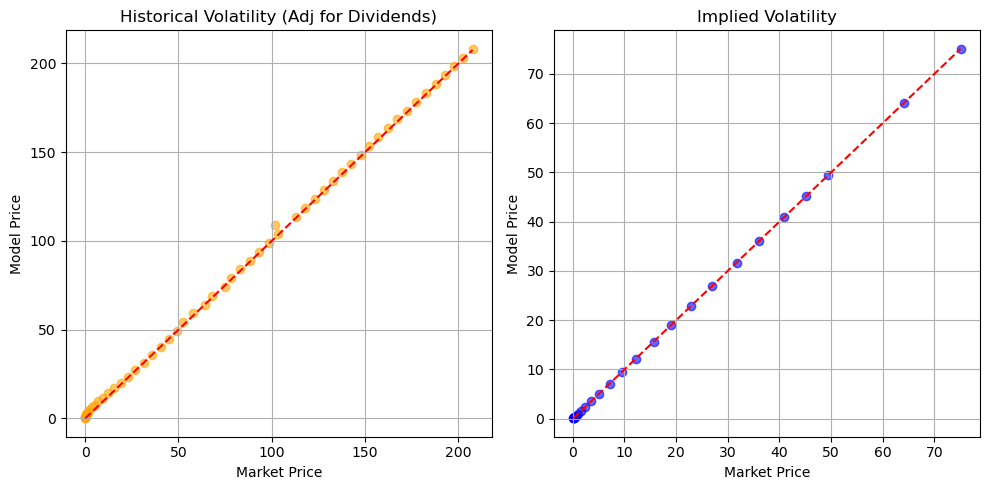

In [19]:
## 9. Visualizations
# Scatter Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(df_hist['Market Price'], df_hist['Model Price'], color='orange', alpha=0.6)
plt.plot([df_hist['Market Price'].min(), df_hist['Market Price'].max()],
         [df_hist['Market Price'].min(), df_hist['Market Price'].max()], 'r--')
plt.title('Historical Volatility (Adj for Dividends)')
plt.xlabel('Market Price')
plt.ylabel('Model Price')
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(df_iv['Market Price'], df_iv['Model Price'], color='blue', alpha=0.6)
plt.plot([df_iv['Market Price'].min(), df_iv['Market Price'].max()],
         [df_iv['Market Price'].min(), df_iv['Market Price'].max()], 'r--')
plt.title('Implied Volatility')
plt.xlabel('Market Price')
plt.ylabel('Model Price')
plt.grid(True)

plt.tight_layout()
plt.show()


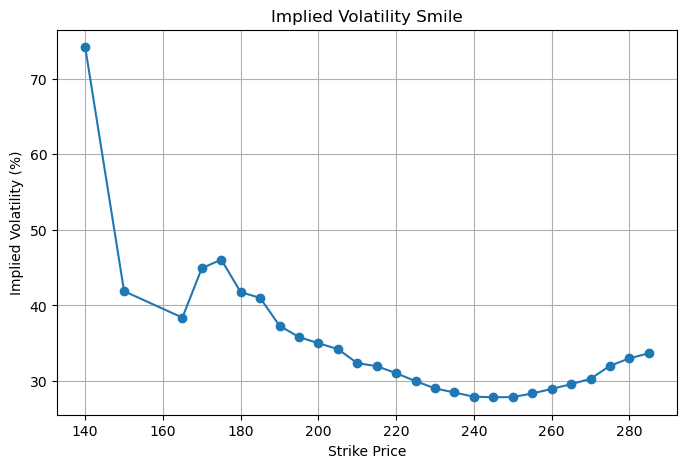

In [21]:
# Volatility Smile
plt.figure(figsize=(8,5))
df_iv_sorted = df_iv.sort_values('Strike')
plt.plot(df_iv_sorted['Strike'], df_iv_sorted['Implied Volatility'] * 100, marker='o')
plt.title('Implied Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.grid(True)
plt.show()

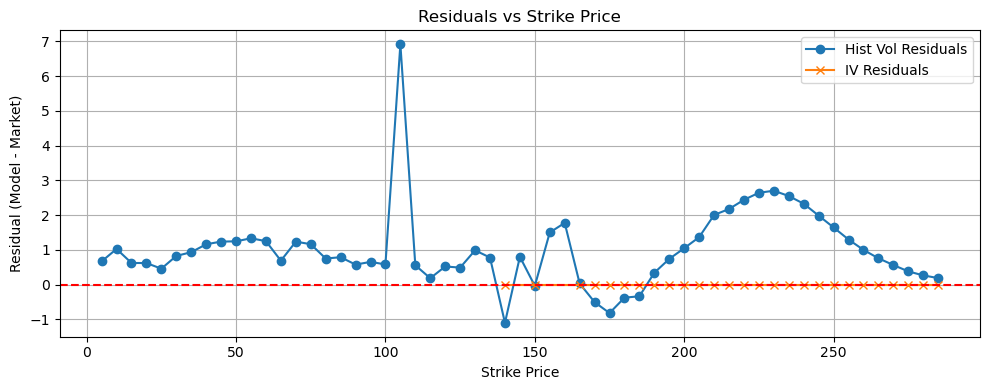

In [23]:
# Residual Analysis
df_hist['Residual'] = df_hist['Model Price'] - df_hist['Market Price']
df_iv['Residual'] = df_iv['Model Price'] - df_iv['Market Price']

plt.figure(figsize=(10,4))
plt.plot(df_hist['Strike'], df_hist['Residual'], label='Hist Vol Residuals', marker='o')
plt.plot(df_iv['Strike'], df_iv['Residual'], label='IV Residuals', marker='x')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Strike Price')
plt.ylabel('Residual (Model - Market)')
plt.title('Residuals vs Strike Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
##Greeks
# Option Price vs Strike
def plot_option_price(ax, df):
    ax.plot(df['Strike'], df['Market Price'], label='Market Price', color='orange')
    ax.plot(df['Strike'], df['Model Price'], label='Model Price', color='blue')
    ax.set_title('Option Price vs Strike')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Option Price')
    ax.legend()
    ax.grid(True)

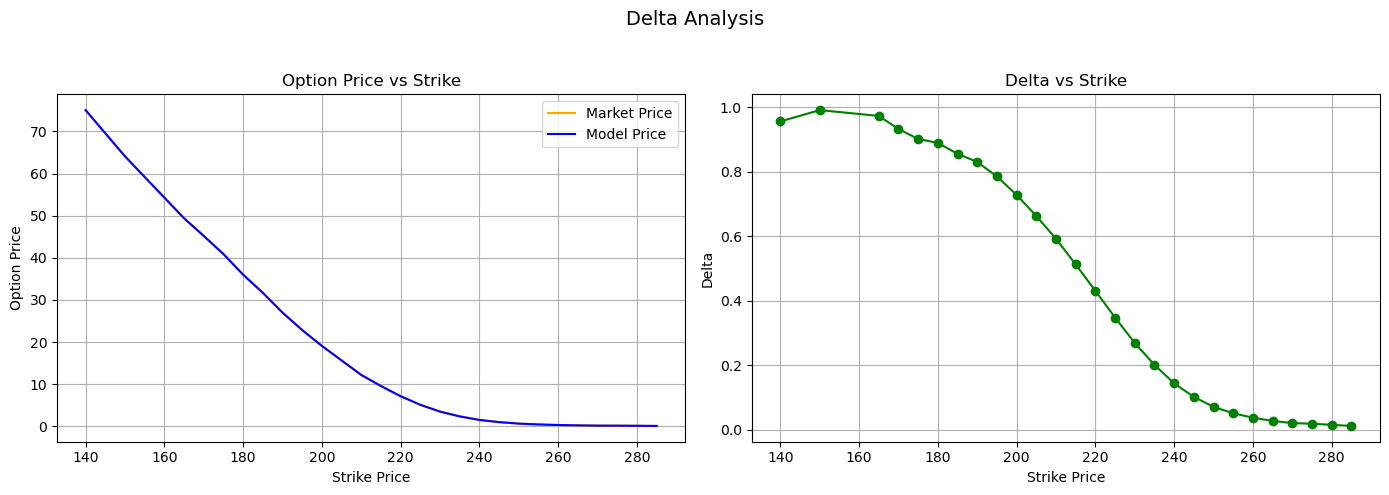

In [31]:
#Delta
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

plot_option_price(axs[0], df_iv)

axs[1].plot(df_iv['Strike'], df_iv['Delta'], marker='o', color='green')
axs[1].set_title('Delta vs Strike')
axs[1].set_xlabel('Strike Price')
axs[1].set_ylabel('Delta')
axs[1].grid(True)

plt.suptitle('Delta Analysis', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

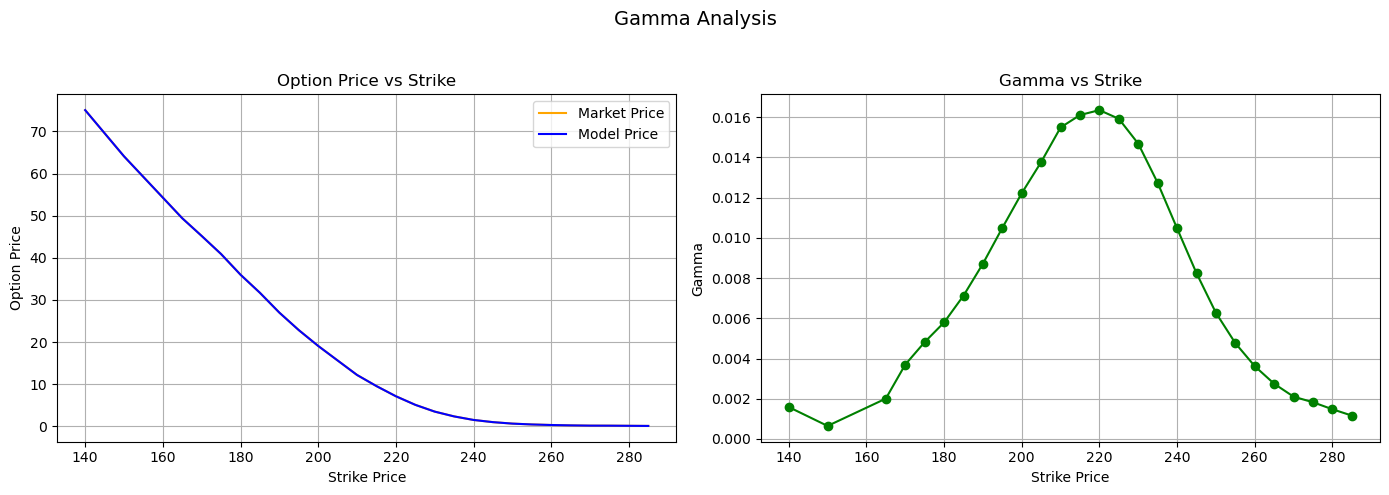

In [33]:
#Gamma
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

plot_option_price(axs[0], df_iv)

axs[1].plot(df_iv['Strike'], df_iv['Gamma'], marker='o', color='green')
axs[1].set_title('Gamma vs Strike')
axs[1].set_xlabel('Strike Price')
axs[1].set_ylabel('Gamma')
axs[1].grid(True)

plt.suptitle('Gamma Analysis', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

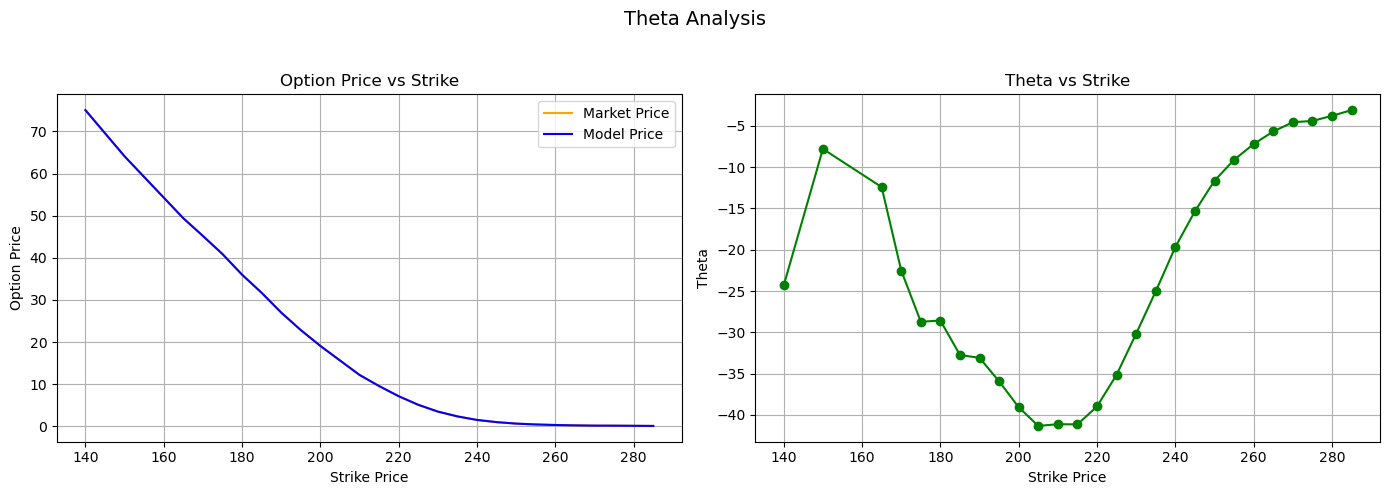

In [35]:
#Theta
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

plot_option_price(axs[0], df_iv)

axs[1].plot(df_iv['Strike'], df_iv['Theta'], marker='o', color='green')
axs[1].set_title('Theta vs Strike')
axs[1].set_xlabel('Strike Price')
axs[1].set_ylabel('Theta')
axs[1].grid(True)

plt.suptitle('Theta Analysis', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

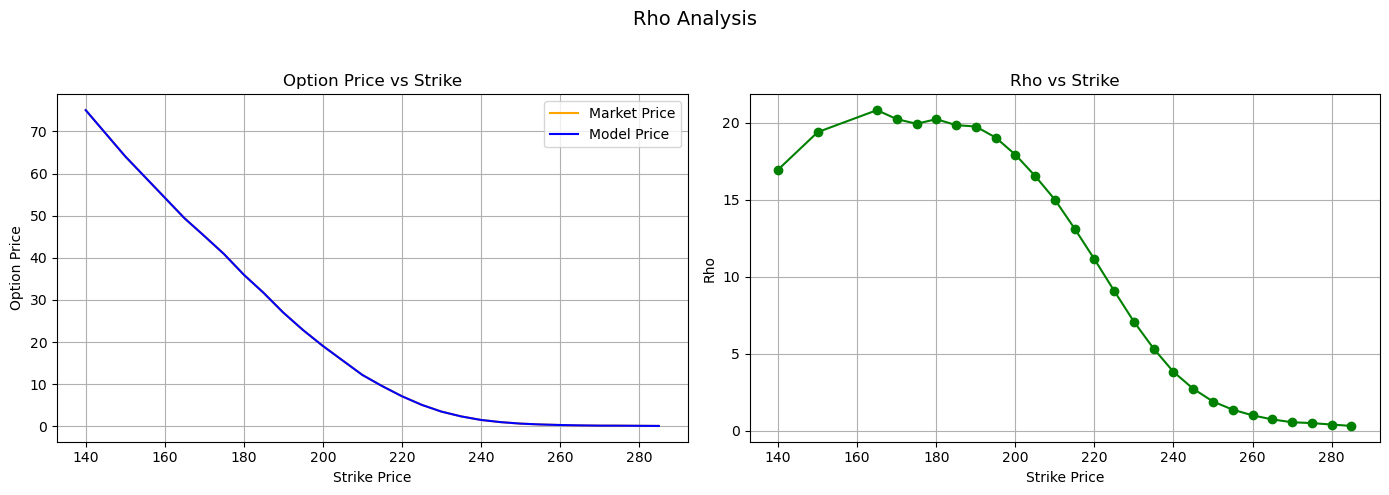

In [37]:
#Rho

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

plot_option_price(axs[0], df_iv)

axs[1].plot(df_iv['Strike'], df_iv['Rho'], marker='o', color='green')
axs[1].set_title('Rho vs Strike')
axs[1].set_xlabel('Strike Price')
axs[1].set_ylabel('Rho')
axs[1].grid(True)

plt.suptitle('Rho Analysis', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

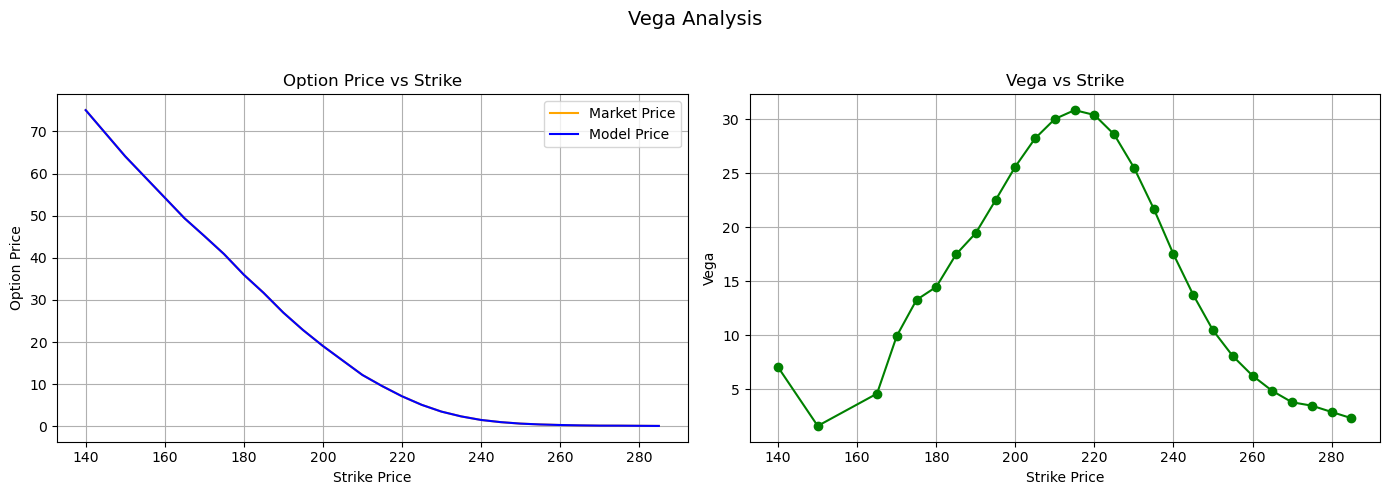

In [39]:
#Vega
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

plot_option_price(axs[0], df_iv)

axs[1].plot(df_iv['Strike'], df_iv['Vega'], marker='o', color='green')
axs[1].set_title('Vega vs Strike')
axs[1].set_xlabel('Strike Price')
axs[1].set_ylabel('Vega')
axs[1].grid(True)

plt.suptitle('Vega Analysis', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

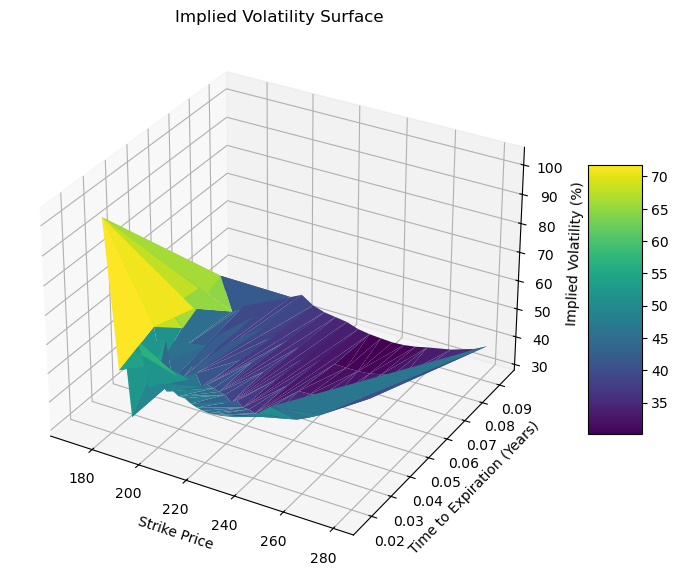

In [41]:
# Volatility Surface
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

all_expiries = ticker.options
surface_data = []
for expiry in all_expiries[:6]:
    opt_chain = ticker.option_chain(expiry)
    calls = opt_chain.calls
    expiry_date = pd.to_datetime(expiry).tz_localize(None)
    T = (expiry_date - current_date).days / 365

    for idx, row in calls.iterrows():
        strike = row['strike']
        market_price = row.get(market_price_col, np.nan)
        if pd.isna(market_price) or market_price < 0.1:
            continue

        imp_vol = implied_vol_solver(market_price, spot_price, strike, T, risk_free_rate, 'call')
        if not np.isnan(imp_vol):
            surface_data.append((strike, T, imp_vol))

df_surface = pd.DataFrame(surface_data, columns=['Strike', 'Time', 'IV'])
X = df_surface['Strike']
Y = df_surface['Time']
Z = df_surface['IV'] * 100

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.viridis, edgecolor='none')
ax.set_title("Implied Volatility Surface")
ax.set_xlabel("Strike Price")
ax.set_ylabel("Time to Expiration (Years)")
ax.set_zlabel("Implied Volatility (%)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()